<a href="https://colab.research.google.com/github/mgozon/DLG-UROP/blob/main/Batch_DLG_Evolution_Iris_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Batch-DLG Evolution - Iris Dataset
This notebook is based on the [Batch-DLG Iris Dataset](https://github.com/mgozon/DLG-UROP/blob/main/Batch_DLG_Iris_Dataset.ipynb), which implements the procedure in [Deep Leakage from Gradients](https://gist.github.com/Lyken17/91b81526a8245a028d4f85ccc9191884) on the Iris Dataset. In particular, a fully connected nueral network is trained using mini-batch gradients which are leaked.

# Setting up Libaries and Utilities

In [2]:
# setting up machine learning/visualization libraries
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
#torch.manual_seed(100) # for generating the same random weights
from torch.utils.data import RandomSampler
from torch.utils.data import random_split
from sklearn.preprocessing import StandardScaler

# setting up optimal device
print(torch.__version__)
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

# utilities for testing
from random import randint
from random import shuffle
from itertools import permutations
from scipy.optimize import linear_sum_assignment
import math
from tqdm.notebook import trange

1.13.1+cu116
Running on cpu


# Setting up Fully Connected Neural Network

In [3]:
# auxiliary functions for NN - convert to onehot and loss function
def label_to_onehot(target, num_classes = 3):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

# ***not equivalent to nn.CrossEntropyLoss(), which combines both nn.LogSoftmax() and nn.NLLLoss()
def cross_entropy_for_onehot(pred, target):
   return torch.mean(torch.sum(- target * torch.log(pred), 1))

In [4]:
# a fully connected neural network with random weights and biases
class FcNet(nn.Module):
    def __init__(self):
        super(FcNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Linear(4, 100),
            act(),
            nn.Linear(100, 100),
            act(),
            nn.Linear(100, 100),
            act(),
            nn.Linear(100, 3),
            nn.Softmax(dim=1),
        )
        
    def forward(self, x):
        out = self.body(x)
        return out

def weights_init(m):
    if hasattr(m, "weight"):
        nn.init.xavier_normal_(m.weight.data)
    if hasattr(m, "bias"):
        nn.init.normal_(m.bias.data)

# instantiation
net = FcNet().to(device)
net.apply(weights_init)
criterion = cross_entropy_for_onehot

# Preprocess Iris Dataset

In [5]:
# preprocess Iris Dataset for training
from sklearn.datasets import load_iris
dst = load_iris()
dst_length = dst.data.shape[0]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dst.data)

train_indices, test_indices = random_split(range(dst_length), [int(dst_length*4/5), int(dst_length*1/5)])
train_indices = train_indices.indices
test_indices = test_indices.indices
train_data = scaled_data[train_indices]; train_target = dst.target[train_indices]
test_data = scaled_data[test_indices]; test_target = dst.target[test_indices]

# Train Model Normally

In [6]:
# train NN without running batch dlg
# Note: converges sometimes to near-optimal predictions
def train_net_Adam(train_data, train_target, batch_size = 32, epochs = 100):
    losses = []
    train_dst_len = train_data.shape[0]
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5) # regularizer may not be necessary
    for epoch in range(epochs):
        optimizer.zero_grad()

        rand_subset = list(RandomSampler(range(train_dst_len), num_samples=batch_size))
        gt_data = torch.tensor(train_data[rand_subset]).to(device)
        gt_label = torch.tensor(train_target[rand_subset]).to(device)
        gt_onehot_label = label_to_onehot(gt_label, num_classes=3)

        output = net(gt_data.float())
        loss = criterion(output, gt_onehot_label)
        loss.backward()
        
        optimizer.step()

        #batch_accuracy = torch.sum(torch.eq(torch.argmax(output, dim=1), gt_label)) / batch_size
        #accuracies.append(batch_accuracy)
        losses.append(loss.detach())
    
    return losses

def test_net(test_data, test_target):
    test_dst_len = test_data.shape[0]
    pred = net(torch.tensor(test_data).float())
    correct = torch.sum(torch.eq(torch.argmax(pred, dim=1), torch.tensor(test_target)))
    print(f'score: {correct}/{test_dst_len}')

In [ ]:
#@title train with LBFGS optimizer

# NOTE: LBFGS isn't converging when using mini-batches
def train_net_LBFGS(train_data, train_target, batch_size = 16, epochs = 100):
    print(train_data); print(train_target)
    train_dst_len = train_data.shape[0]
    optimizer = torch.optim.LBFGS(net.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lambda epoch: 0.99)

    for epoch in range(epochs):
        rand_subset = list(RandomSampler(range(train_dst_len), num_samples=batch_size))
        # print('epoch, randset: ', epoch, rand_subset)
        gt_data = torch.tensor(train_data[rand_subset]).to(device)
        gt_label = torch.tensor(train_target[rand_subset]).to(device)
        gt_onehot_label = label_to_onehot(gt_label, num_classes=3)
        #print('lbfgs: ', gt_data, gt_onehot_label)
        
        def closure():
            optimizer.zero_grad()
            output = net(gt_data.float())
            loss = criterion(output, gt_onehot_label)
            loss.backward()
            #print(f'output: {output}, onehot_label: {gt_onehot_label}')
            print('loss: ', loss)
            return loss
      
        optimizer.step(closure)
        scheduler.step()

score: 28/30


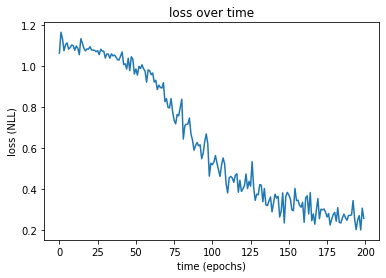

In [7]:
# note that parameters batch_size and epochs are tuned to yield a more accurate model
net.apply(weights_init)
batch_size = 32 # this affects the smoothness of the loss graph
epochs = 200
losses = train_net_Adam(train_data, train_target, batch_size, epochs)
test_net(test_data, test_target)

plt.plot(list(range(epochs)), losses)
plt.title('loss over time')
plt.xlabel('time (epochs)')
plt.ylabel('loss (NLL)')
plt.show()

# Batch-DLG and Optimal Input Assignment

In [168]:
#@title Batch-DLG with LBFGS
# ***NOTE - this gives NaNs when ReLU is used since it requires a differentiable loss function
# --> also possibly due to PyTorch implementation error - https://github.com/pytorch/pytorch/issues/5953)

# DLG algorithm on a given set of flowers and returns the hypothesized input
def batch_DLG(original_dy_dx, batch_size, gt_data_len, gt_onehot_label_len, verbose = False):
    losses = []

    # identify (data, label) using LBFGS on the squared difference between the original and guessed gradient
    dummy_data = torch.randn(batch_size, gt_data_len).to(device).requires_grad_(True)
    dummy_label = torch.randn(batch_size, gt_onehot_label_len).to(device).requires_grad_(True)
    optimizer_dlg = torch.optim.LBFGS((dummy_data, dummy_label), max_iter=20)

    global opt_steps; opt_steps = 0
    for epoch in range(100):
        # closure function needed for LBFGS optimizer
        def closure():
            global opt_steps; opt_steps += 1

            # compute gradient of dummy data/label
            optimizer_dlg.zero_grad()
            pred = net(dummy_data)
            dummy_onehot_label = F.softmax(dummy_label, dim=1)
            dummy_loss = criterion(pred, dummy_onehot_label)
            dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
            
            # compute loss function, i.e. the SE of the gradients
            grad_diff = 0
            for gx, gy in zip(dummy_dy_dx, original_dy_dx):
                grad_diff += ((gx - gy) ** 2).sum()
            
            grad_diff.backward()
            return grad_diff
        
        # perform GD and log information
        optimizer_dlg.step(closure)
        current_loss = closure()
        losses.append(current_loss.item())

        if (verbose):
            print(current_loss)
        if (current_loss < 1e-9):
            break
        # setting an upper limit on the number of optimization steps (e.g. limited attacking capability)
        #if (opt_steps >= 80): 
        #    break
    
    return dummy_data, opt_steps, losses

In [159]:
#@title Batch-DLG with Adam
# note: optimization should not be used on one optimizer since Adam requires gradient history to perform updates --> see code block below
# this appears to take longer to converge but may give better results than LBFGS on batches (without using optimization)

# DLG algorithm on a given set of flowers and returns the hypothesized input
def batch_DLG_Adam(original_dy_dx, batch_size, gt_data_len, gt_onehot_label_len, verbose = False):
    losses = []

    # identify (data, label) using LBFGS on the squared difference between the original and guessed gradient
    dummy_data = torch.randn(batch_size, gt_data_len).to(device).requires_grad_(True)
    dummy_label = torch.randn(batch_size, gt_onehot_label_len).to(device).requires_grad_(True)
    optimizer_dlg = torch.optim.Adam((dummy_data, dummy_label), lr=1, weight_decay=1e-9) # optimal learning rate seems to depend on the batch size of the dlg
    #scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer_dlg, lambda epoch: 0.999)

    opt_steps = 500 * batch_size
    for epoch in trange(opt_steps):
        optimizer_dlg.zero_grad()
        pred = net(dummy_data)
        dummy_onehot_label = F.softmax(dummy_label, dim=1)
        dummy_loss = criterion(pred, dummy_onehot_label)
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
        
        # compute loss function, i.e. the SE of the gradients
        grad_diff = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx):
            grad_diff += ((gx - gy) ** 2).sum()

        grad_diff.backward()

        # Adam depends on past updates, and so this doesn't really work - loss fluctuates in dlg attack *significantly* when used
        # only update a single dummy_data/dummy_label at a time
        # mult = torch.zeros([batch_size, 1])
        # mult[epoch%batch_size, 0] = 1
        # dummy_data.grad *= mult; dummy_label.grad *= mult
        
        optimizer_dlg.step()
        #scheduler.step()
        losses.append(grad_diff.item())

        if verbose:
            print(grad_diff)
        if (grad_diff < 1e-9):
            break
    
    return dummy_data, opt_steps, losses

In [169]:
#@title Batch-DLG with Adam - individual optimizers
# this doesn't seem to converge nearly as well as a single Adam optimizer

# DLG algorithm on a given set of flowers and returns the hypothesized input
def batch_DLG_Adam2(original_dy_dx, batch_size, gt_data_len, gt_onehot_label_len, verbose = False):
    losses = []

    dummy_data = [torch.randn(1, 4).to(device).requires_grad_(True) for i in range(batch_size)]
    dummy_label = [torch.randn(1, 3).to(device).requires_grad_(True) for i in range(batch_size)]
    optimizer_dlg = [torch.optim.Adam((dummy_data[i], dummy_label[i]), lr=1, weight_decay=1e-9) for i in range(batch_size)]
    #scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer_dlg, lambda epoch: 0.999)

    opt_steps = 500 * batch_size
    for epoch in trange(opt_steps):
        idx = epoch % batch_size
        optimizer_dlg[idx].zero_grad()
        pred = [net(dummy_data[i]) for i in range(batch_size)]
        dummy_onehot_labels = [F.softmax(dummy_label[i], dim=1) for i in range(batch_size)]
        dummy_loss = sum([criterion(pred[i], dummy_onehot_labels[i]) for i in range(batch_size)]) / batch_size
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
        
        # compute loss function, i.e. the SE of the gradients
        grad_diff = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx):
            grad_diff += ((gx - gy) ** 2).sum()

        grad_diff.backward()
        optimizer_dlg[idx].step()
        #scheduler.step()
        losses.append(grad_diff.item())

        if verbose:
            print(grad_diff)
        if (grad_diff < 1e-9):
            break
    
    return dummy_data, opt_steps, losses

In [14]:
#@title Batch-DLG with SGD
# this doesn't seem to converge nearly as well as LBFGS even with optimization

# DLG algorithm on a given set of flowers and returns the hypothesized input
def batch_DLG_SGD(original_dy_dx, batch_size, gt_data_len, gt_onehot_label_len, verbose = False):
    losses = []

    # identify (data, label) using LBFGS on the squared difference between the original and guessed gradient
    dummy_data = torch.randn(batch_size, gt_data_len).to(device).requires_grad_(True)
    dummy_label = torch.randn(batch_size, gt_onehot_label_len).to(device).requires_grad_(True)
    optimizer_dlg = torch.optim.SGD((dummy_data, dummy_label), lr=1)#, momentum=0.001)#, weight_decay=1e-9)
    scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer_dlg, lambda epoch: 0.99)

    opt_steps = 1000 * batch_size
    for epoch in trange(opt_steps):
        optimizer_dlg.zero_grad()
        pred = net(dummy_data)
        dummy_onehot_label = F.softmax(dummy_label, dim=1)
        dummy_loss = criterion(pred, dummy_onehot_label)
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
        
        # compute loss function, i.e. the SE of the gradients
        grad_diff = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx):
            grad_diff += ((gx - gy) ** 2).sum()

        grad_diff.backward()

        # only update a single dummy_data/dummy_label at a time
        mult = torch.zeros([batch_size, 1])
        mult[epoch%batch_size, 0] = 1
        dummy_data.grad *= mult; dummy_label.grad *= mult
        
        optimizer_dlg.step()
        scheduler.step()
        losses.append(grad_diff.item())

        if verbose:
            print(grad_diff)
        if (grad_diff < 1e-9):
            break
    
    return dummy_data, opt_steps, losses

In [8]:
# find best linear sum assignment
def assign_guess(guess, gt_dataset, n, verbose = False):
    cost_matrix = [[math.sqrt(torch.sum((guess[i]-gt_dataset[j])**2).item()) for j in range(n)] for i in range(n)]
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    best_MSE = sum([cost_matrix[row_ind[i]][col_ind[i]] for i in range(n)]) / n
    if (verbose):
        print('best guessed-actual assignment: ', col_ind)
        print('best_MSE: ', best_MSE)

    guess_perm = torch.zeros(gt_dataset.shape)
    for i in range(n):
        guess_perm[col_ind[i]] = guess[i]

    return guess_perm

# Testing Single Batch DLG

In [9]:
# process specific batch gradient of flowers
def batch_grad(flower_indices):
    n = len(flower_indices)
    # flower_indices = torch.tensor(flower_indices)

    gt_data = torch.tensor(dst.data[flower_indices]).to(device)
    gt_label = torch.tensor(dst.target[flower_indices]).to(device)
    gt_onehot_label = label_to_onehot(gt_label, num_classes=3)

    out = net(gt_data.float())
    loss = criterion(out, gt_onehot_label)
    batch_dy_dx = torch.autograd.grad(loss, net.parameters())
    original_dy_dx = list((_.detach().clone() for _ in batch_dy_dx)) # share the gradients with other clients
    
    return original_dy_dx, gt_data, gt_label

[40, 63, 33, 101]


  0%|          | 0/4000 [00:00<?, ?it/s]

gt data vs guess perm: 
tensor([5.0000, 3.5000, 1.3000, 0.3000], dtype=torch.float64) tensor([ 1.4787,  0.4909,  0.6923, -0.2290], grad_fn=<SelectBackward0>) AE:  4.701420497582232
tensor([6.1000, 2.9000, 4.7000, 1.4000], dtype=torch.float64) tensor([ 0.5416,  1.1975,  1.5227, -0.7629], grad_fn=<SelectBackward0>) AE:  6.969071232445326
tensor([5.5000, 4.2000, 1.4000, 0.2000], dtype=torch.float64) tensor([ 0.0799,  1.2146, -1.0400,  0.9683], grad_fn=<SelectBackward0>) AE:  6.695827711383465
tensor([5.8000, 2.7000, 5.1000, 1.9000], dtype=torch.float64) tensor([0.2930, 1.7440, 0.0896, 1.7538], grad_fn=<SelectBackward0>) AE:  7.507776878549403


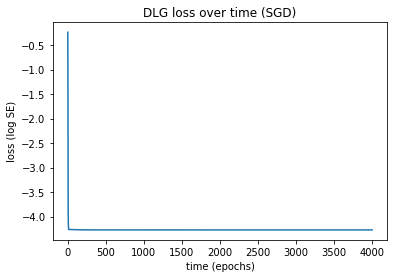

In [15]:
# testing batch-DLG with Adam
net.apply(weights_init) # see how much easier it is to attack
batch_size = 4
flower_indices = list(RandomSampler(range(dst.data.shape[0]), num_samples=batch_size))
print(flower_indices)
batch_dy_dx, gt_data, gt_label = batch_grad(flower_indices)

dummy_data, _, losses = batch_DLG_SGD(batch_dy_dx, batch_size, 4, 3, verbose = False)
guess_perm = assign_guess(dummy_data, gt_data, batch_size)
print('gt data vs guess perm: ')
for i in range(batch_size):
    print(gt_data[i], guess_perm[i], 'AE: ', math.sqrt(torch.sum((gt_data[i]-guess_perm[i])**2).item()))

plt.plot(torch.log(torch.tensor(losses)))
plt.title('DLG loss over time (SGD)')
plt.xlabel('time (epochs)')
plt.ylabel('loss (log SE)')
plt.savefig('dlg8-SGD.png', dpi=300)

# Leakage Statistics

In [ ]:
def compute_stats(n_elts, guess_perm, gt_data):
    MSE = 0
    SEs = []
    n_errors = []
    cos_angles = []
    for i in range(n_elts):
        SE = torch.sum((guess_perm[i]-gt_data[i])**2).item()
        SEs.append(SE); MSE += SE

        n_error = (torch.sum((guess_perm[i]-gt_data[i])**2) / (torch.linalg.norm(gt_data[i])**2)).item()
        n_errors.append(n_error)

        cos_angle = (torch.sum(guess_perm[i]*gt_data[i]).item() / (torch.linalg.norm(gt_data[i]) * torch.linalg.norm(guess_perm[i]))).item()
        cos_angles.append(cos_angle)

    MSE /= n_elts

    return SEs, MSE, n_errors, cos_angles

# Training Model with Batch-DLG

In [ ]:
def train_net_Adam_DLG(train_data, train_target, batch_size = 32, epochs = 100, verbose = False, dlg_rate = 10):
    train_dst_len = train_data.shape[0]
    optimizer = torch.optim.Adam(net.parameters()) #lr=0.001)

    # statistics
    losses = []
    dlg_timestamps = []
    dlg_SEs = []
    dlg_MSE = []
    dlg_n_errors = []
    dlg_cos_angles = []

    for epoch in trange(epochs):
        optimizer.zero_grad()

        rand_subset = list(RandomSampler(range(train_dst_len), num_samples=batch_size))
        # print('epoch, randset: ', epoch, rand_subset)
        gt_data = torch.tensor(train_data[rand_subset]).to(device)
        gt_label = torch.tensor(train_target[rand_subset]).to(device)
        gt_onehot_label = label_to_onehot(gt_label, num_classes=3)

        output = net(gt_data.float())
        #print('adam: ', output.tolist(), gt_onehot_label.tolist())
        loss = criterion(output, gt_onehot_label)

        # Perform DLG ---------------------------------------------------------------

        if (epoch%dlg_rate == 0):
            batch_dy_dx = torch.autograd.grad(loss, net.parameters(), retain_graph = True)
            original_dy_dx = list((_.detach().clone() for _ in batch_dy_dx)) # share the gradients with other clients
            guess, steps, _ = batch_DLG(original_dy_dx, batch_size, 4, 3, verbose=False)
            guess_perm = assign_guess(guess, gt_data, batch_size, verbose)
            SEs, MSE, n_errors, cos_angles = compute_stats(batch_size, guess_perm, gt_data)
            dlg_SEs.append(SEs)
            dlg_MSE.append(MSE)
            dlg_n_errors.append(n_errors)
            dlg_cos_angles.append(cos_angles)
            dlg_timestamps.append(epoch)

            if (verbose):
                print('dlg results at epoch', epoch, '-', scaler.inverse_transform(gt_data.detach()), scaler.inverse_transform(guess_perm.detach()))

        # end of DLG ----------------------------------------------------------------

        # issue: running batch_DLG seems to ruin the stored gradients of the parameters
        # consider creating a separate ml model and running dlg on that
        # inefficient - REMOVE -----------------------------------------------------------------------------
        optimizer.zero_grad()
        loss = criterion(output, gt_onehot_label)
        # end of REMOVE ------------------------------------------------------------------------------------

        loss.backward()
        if (verbose):
            print('current loss: ', loss)
        
        optimizer.step()

        #batch_accuracy = torch.sum(torch.eq(torch.argmax(output, dim=1), gt_label)) / batch_size
        #accuracies.append(batch_accuracy)
        losses.append(loss.detach())
    
    return losses, dlg_timestamps, dlg_SEs, dlg_MSE, dlg_n_errors, dlg_cos_angles

# Results

In [ ]:
# results of training a model + dlg
net.apply(weights_init)
epochs = 1000
batch_size = 16
dlg_rate = 10
verbose = True
losses, dlg_timestamps, dlg_SEs, dlg_MSE, dlg_n_errors, dlg_cos_angles = train_net_Adam_DLG(train_data, train_target, batch_size, epochs, verbose, dlg_rate)
test_net(test_data, test_target)

  0%|          | 0/1000 [00:00<?, ?it/s]

best guessed-actual assignment:  [ 5  4 10  8  7  3  2  0 14 13  6 15  9 11  1 12]
best_MSE:  2.6080824419169564
dlg results at epoch 0 - [[5.8 2.7 5.1 1.9]
 [5.7 2.5 5.  2. ]
 [5.  3.5 1.6 0.6]
 [7.7 2.6 6.9 2.3]
 [5.5 2.6 4.4 1.2]
 [5.9 3.2 4.8 1.8]
 [6.4 2.7 5.3 1.9]
 [5.  3.2 1.2 0.2]
 [5.1 3.3 1.7 0.5]
 [5.1 3.8 1.9 0.4]
 [6.4 3.2 4.5 1.5]
 [5.1 3.5 1.4 0.2]
 [5.8 4.  1.2 0.2]
 [6.7 3.1 5.6 2.4]
 [7.2 3.6 6.1 2.5]
 [5.8 2.8 5.1 2.4]] [[ 5.82094184  2.7182916   6.89461558  1.88189802]
 [ 6.15809736  2.26846363  5.79693167  2.70756936]
 [ 5.98616123  3.78274707  3.05185323  1.44837919]
 [ 7.50921764  2.35428823  5.26457077  1.76299473]
 [ 5.64310152  2.66420377  4.79605968  2.00694996]
 [ 6.42686947  2.8284191   3.48540161  2.43292089]
 [ 7.00347744  2.72353953  5.35420505  2.33489351]
 [ 6.94581984  2.0945628   3.4993789   0.56932496]
 [ 5.4654514   2.97496497  4.07163826  0.29894293]
 [ 4.54999046  4.00525532 -0.33785042  0.77413078]
 [ 7.10265054  2.92819422  5.85969053  1.893660

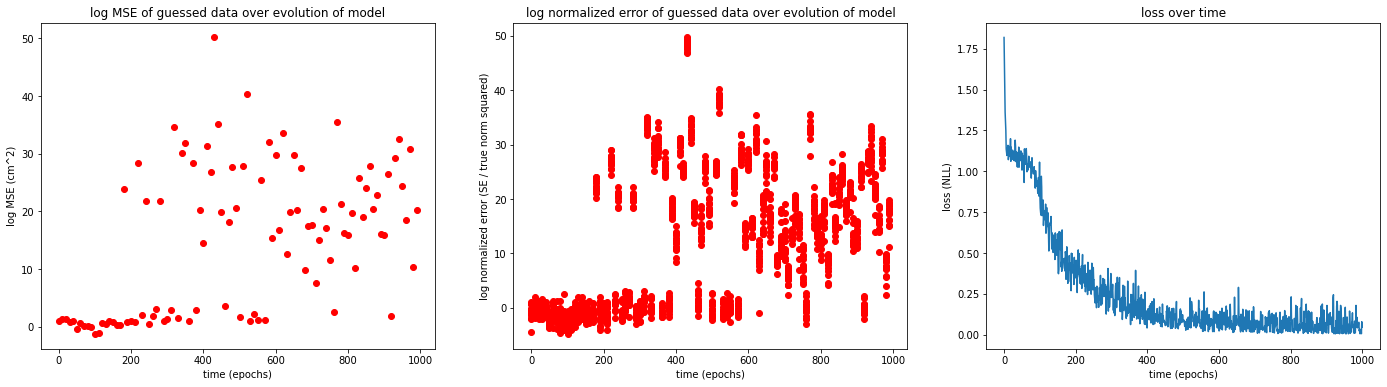

In [ ]:
# create summary plots of MSE and normalized errors over time
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

axs[0].plot(dlg_timestamps, torch.log(torch.tensor(dlg_MSE)), 'ro')
axs[0].set(title='log MSE of guessed data over evolution of model', xlabel='time (epochs)', ylabel='log MSE (cm^2)')

axs[1].plot(torch.tensor(dlg_timestamps).repeat_interleave(batch_size), torch.log(torch.tensor(dlg_n_errors).view(-1)), 'ro')
axs[1].set(title='log normalized error of guessed data over evolution of model', xlabel='time (epochs)', ylabel='log normalized error (SE / true norm squared)')

axs[2].plot(list(range(epochs)), losses)
axs[2].set(title='loss over time', xlabel='time (epochs)', ylabel='loss (NLL)')

plt.savefig('train_DLG_16.png', dpi=300)

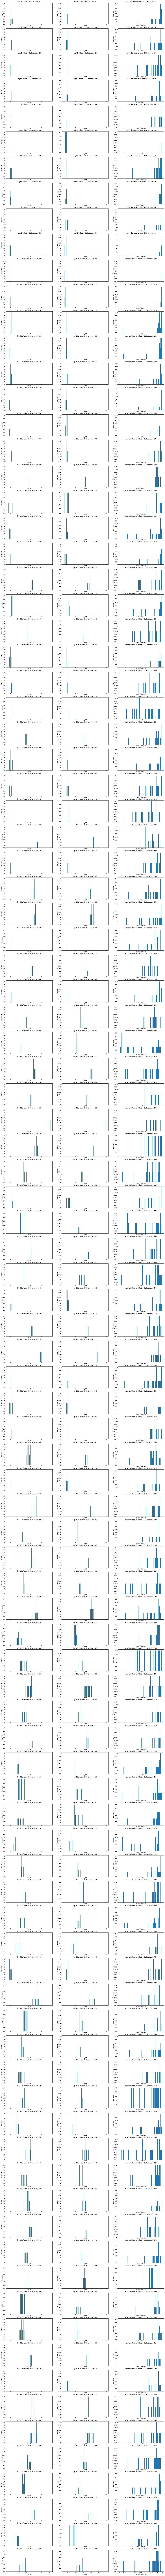

In [ ]:
# evolution of SEs, normalized errors, cosine distances
fig, axs = plt.subplots(len(dlg_timestamps), 3, sharex='col', figsize=(24, len(dlg_timestamps)*4))

for i in range(len(dlg_timestamps)):
    axs[i, 0].hist(torch.log(torch.tensor(dlg_SEs[i])), 50)
    axs[i, 0].set(title=f'log SE of batch DLG at epoch {dlg_timestamps[i]}', xlabel='log SE', ylabel='frequency')

    axs[i, 1].hist(torch.log(torch.tensor(dlg_n_errors[i])), 50)
    axs[i, 1].set(title=f'log NE of batch DLG at epoch {dlg_timestamps[i]}', xlabel='log NE', ylabel='frequency')

    axs[i, 2].hist(dlg_cos_angles[i], 50)
    axs[i, 2].set(title=f'cosine distances of batch DLG at epoch {dlg_timestamps[i]}', xlabel='cosine distance', ylabel='frequency')

# Notes

In [ ]:
# Todo
# look at BRAZPD medical dataset --> see notebook that has the baseline features --> try 1 data point before batch
# see if larger dataset + batch size + trained network make dlg harder
# write the abstract for next week's meeting
# meet at 4:15 pm next Friday

# future tasks -----------------------------------------------------------
# look at dp
# look at papers more related to FL
# estimate how quickly the model can be trained + attacked
# icml workshop for results
# consider other medical dataset
# possible idea - PCA with image tasks to capture similarity between reconstructed and true input data
# consider dropout with a probability like ~ 0.20-0.25 (or even, aggressively, 0.5 - good for generalization)